# Clustering and Prediction

### Attempt to cluster police districts by crime data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
%matplotlib inline
incidents = pd.read_csv('../data/crime.csv')
incidents.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat
0,18,3,2009-10-02 14:24:00,2009-10-02,14:24:00,14,200918067518,S 38TH ST / MARKETUT ST,800.0,Other Assaults,NaN,2009-10,NaN,NaN
1,14,1,2009-05-10 00:55:00,2009-05-10,00:55:00,0,200914033994,8500 BLOCK MITCH,2600.0,All Other Offenses,NaN,2009-05,NaN,NaN
2,25,J,2009-08-07 15:40:00,2009-08-07,15:40:00,15,200925083199,6TH CAMBRIA,800.0,Other Assaults,NaN,2009-08,NaN,NaN
3,35,D,2009-07-19 01:09:00,2009-07-19,01:09:00,1,200935061008,5500 BLOCK N 5TH ST,1500.0,Weapon Violations,20.0,2009-07,-75.130477,40.036389
4,9,R,2009-06-25 00:14:00,2009-06-25,00:14:00,0,200909030511,1800 BLOCK WYLIE ST,2600.0,All Other Offenses,8.0,2009-06,-75.166350,39.969532


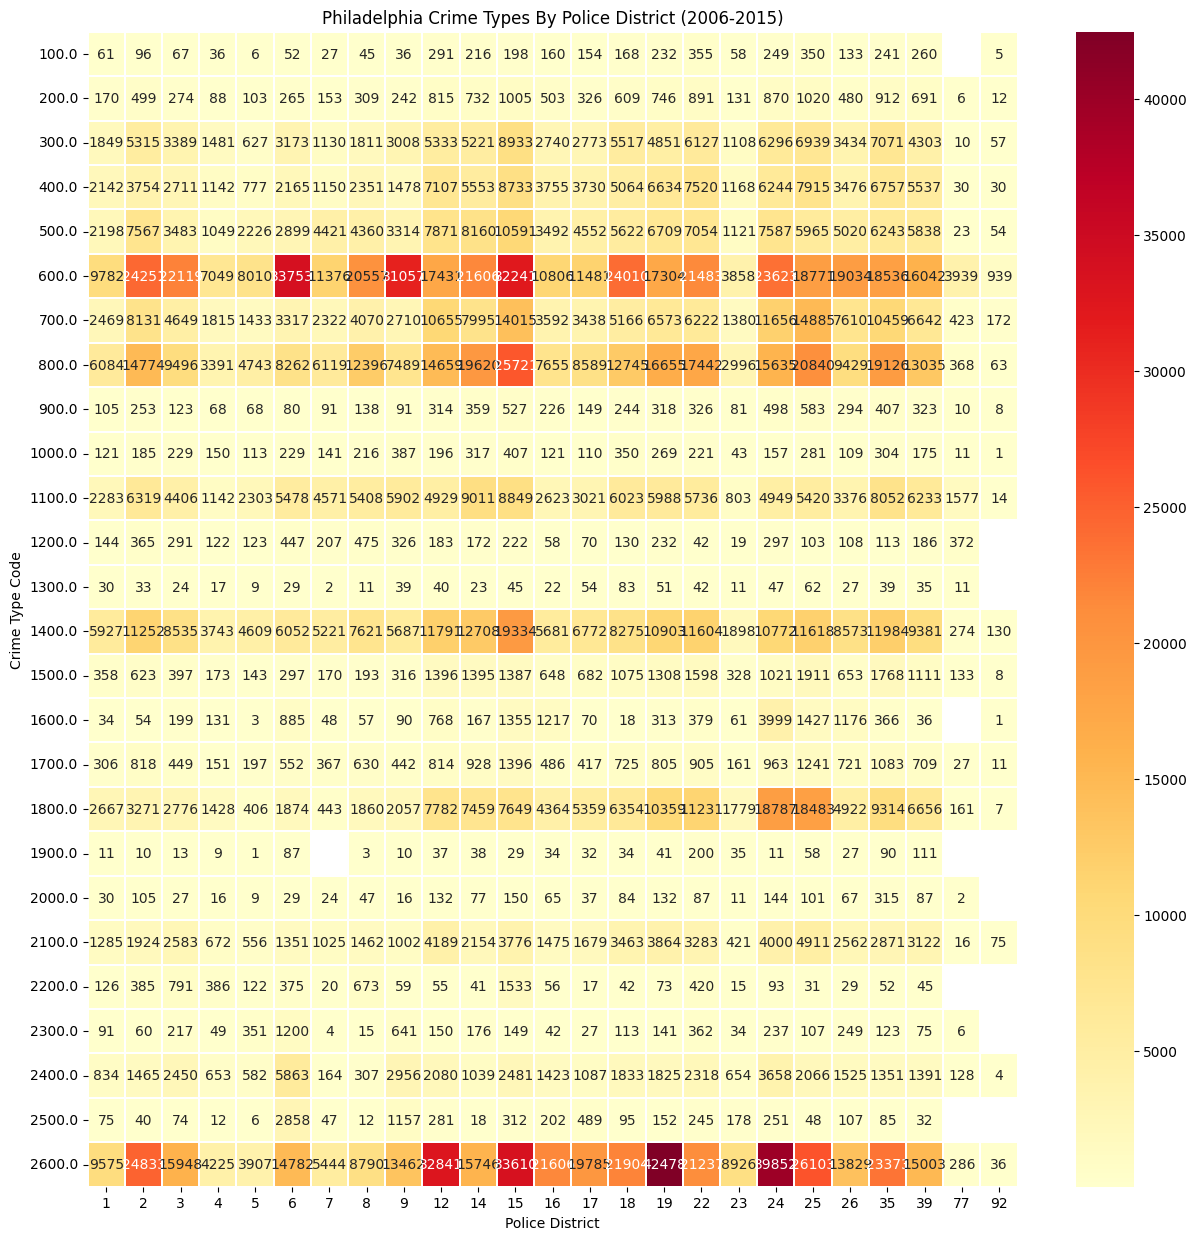

In [3]:
crime_data_type_dist = incidents.groupby(['UCR_General', 'Dc_Dist']).size()
crime_data_type_dist = crime_data_type_dist.apply(int)
crime_data_type_dist_df = crime_data_type_dist.to_frame()
crime_data_type_dist_pt = pd.pivot_table(crime_data_type_dist_df, index=['UCR_General'], columns=['Dc_Dist'])[0] # Get rid of '0 column'

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data=crime_data_type_dist_pt, annot=True, linewidths=0.1, fmt='g', cmap="YlOrRd", ax=ax)
plt.title("Philadelphia Crime Types By Police District (2006-2015)")
plt.xlabel("Police District")
plt.ylabel("Crime Type Code")
plt.show()

Crime Types: ['Other Assaults' 'All Other Offenses' 'Weapon Violations' 'Thefts'
 'Burglary Non-Residential' 'Aggravated Assault Firearm'
 'Theft from Vehicle' 'Disorderly Conduct' 'Vandalism/Criminal Mischief'
 'Arson' 'Fraud' 'Robbery No Firearm' 'Vagrancy/Loitering'
 'Motor Vehicle Theft' 'Recovered Stolen Motor Vehicle' 'Robbery Firearm'
 'Embezzlement' 'Rape' 'DRIVING UNDER THE INFLUENCE'
 'Forgery and Counterfeiting' 'Narcotic / Drug Law Violations'
 'Burglary Residential' 'Other Sex Offenses (Not Commercialized)'
 'Liquor Law Violations' 'Aggravated Assault No Firearm'
 'Homicide - Criminal' 'Gambling Violations'
 'Prostitution and Commercialized Vice' 'Public Drunkenness'
 'Receiving Stolen Property' 'Homicide - Gross Negligence'
 'Offenses Against Family and Children' 'Homicide - Justifiable' nan]


/Users/amandah/Desktop/gopipelines/.conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


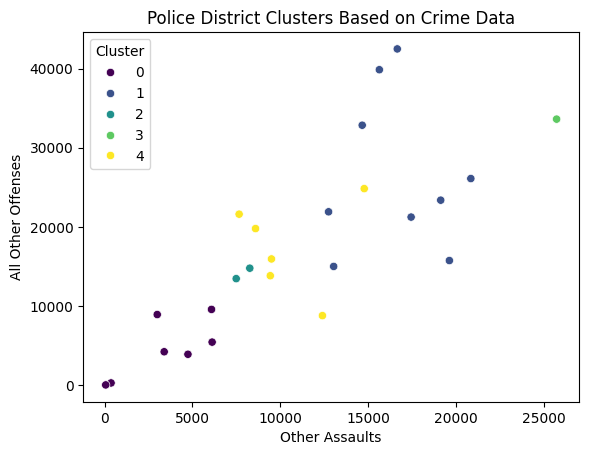

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming 'incidents' DataFrame is already loaded with crime data

# Identifying crime types
crime_types = incidents['Text_General_Code'].unique()
print("Crime Types:", crime_types)

# Feature engineering: pivot table with crime types as columns, police districts as rows
crime_features = incidents.pivot_table(index='Dc_Dist', columns='Text_General_Code', 
                                       values='Dc_Key', aggfunc='count', fill_value=0)

# Data preprocessing: standardization of features
scaler = StandardScaler()
crime_features_scaled = scaler.fit_transform(crime_features)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
district_clusters = kmeans.fit_predict(crime_features_scaled)

# Adding the cluster labels to the original DataFrame
crime_features['Cluster'] = district_clusters

# Selecting two crime types for visualization (replace with actual crime types)
# For example, using the first two crime types from the list
if len(crime_types) >= 2:
    crime_type_1 = crime_types[0]
    crime_type_2 = crime_types[1]

    sns.scatterplot(data=crime_features, x=crime_type_1, y=crime_type_2, hue='Cluster', palette='viridis')
    plt.title('Police District Clusters Based on Crime Data')
    plt.xlabel(crime_type_1)
    plt.ylabel(crime_type_2)
    plt.legend(title='Cluster')
    plt.show()
else:
    print("Not enough crime types for visualization.")



In [27]:
import geopandas as gpd

# Load the GeoJSON file
gdf = gpd.read_file('../data/Boundaries_District.geojson')

# Convert 'DISTRICT_' in gdf to the same type as the index in crime_features
gdf['DISTRICT_'] = gdf['DISTRICT_'].astype(crime_features.index.dtype)

# Join the GeoDataFrame with the cluster labels without setting 'DISTRICT_' as index first
gdf_merged = gdf.merge(crime_features[['Cluster']], left_on='DISTRICT_', right_index=True)

# Checking the first few rows to ensure the join worked
gdf_merged.head()

,OBJECTID,AREA,PERIMETER,DISTRICT_,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,Cluster
0,343,None,69282.588463,16,None,16,None,16,39th St. & Lancaster Ave.,686-3160,SWPD,1.216700e+08,1.927226e+07,27575.079183,"POLYGON ((-75.19957 40.00912, -75.20097 40.009...",4
1,344,None,33150.154961,17,None,17,None,17,20th St. & Federal St.,686-3170,SPD,5.786368e+07,9.154950e+06,13179.953350,"POLYGON ((-75.16599 39.94184, -75.16585 39.942...",4
2,345,None,54403.930038,18,None,18,None,18,55th St. & Pine St.,686-3180,SWPD,9.881929e+07,1.564117e+07,21629.610687,"POLYGON ((-75.18466 39.94851, -75.18368 39.949...",1
3,346,None,51597.051603,35,None,35,None,35,N. Broad St. & Champlost St.,686-3350,NWPD,1.544309e+08,2.450685e+07,20554.869138,"POLYGON ((-75.13011 40.05789, -75.13307 40.059...",1
4,347,None,58075.014444,39,None,39,None,39,22nd St. & Hunting Park Ave.,686-3390,NWPD,1.578976e+08,2.503787e+07,23123.580262,"POLYGON ((-75.17892 40.03175, -75.17908 40.031...",1


In [28]:
import folium

# Assuming you have latitude and longitude for the center of the map
map_center_latitude = 40.0  # Replace with the actual latitude
map_center_longitude = -75.1  # Replace with the actual longitude

# Create a base map
m = folium.Map(location=[map_center_latitude, map_center_longitude], zoom_start=11)

# Plot using Folium
folium.Choropleth(
    geo_data=gdf_merged.to_json(),
    data=gdf_merged,
    columns=['DISTRICT_', 'Cluster'],
    key_on='feature.properties.DISTRICT_',
    fill_color='YlOrRd',
    legend_name='Crime Data Clusters'
).add_to(m)

# Display the map
m


### Attempt to predict number of incidents in each police district in each year

In [39]:
incidents['Dispatch_Date'] = pd.to_datetime(incidents['Dispatch_Date'])

incidents['Year'] = incidents['Dispatch_Date'].dt.year

incidents['Year'] = pd.to_datetime(incidents['Dispatch_Date']).dt.year
incidents['Dc_Dist'] = incidents['Dc_Dist'].astype(str)

# Aggregate the data
cases_per_year_district = incidents[incidents['Year'] != 2016].groupby(['Year', 'Dc_Dist']).size().unstack(fill_value=0)

from sklearn.linear_model import LinearRegression

# Prepare training data
X_train = cases_per_year_district.index.values.reshape(-1, 1)  # Years as features
y_train = cases_per_year_district.values  # Cases as target

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict for 2016
X_test = np.array([[2016]])
y_pred = model.predict(X_test)

# Add the predictions to the DataFrame
cases_per_year_district.loc[2016] = y_pred.flatten()

# Display the predictions
cases_per_year_district.loc[2016]

Dc_Dist
1      2511.950376
12     7688.843609
14     6726.103759
15    10659.777444
16     4391.971429
17     3621.457143
18     6582.968421
19    10320.673684
2      7320.962406
22     9907.616541
23    -1577.685714
24    10177.912782
25     7313.508271
26     5145.091729
3      7174.001504
35     7068.842105
39     6000.413534
4     -1605.079699
5      1464.267669
6      5390.288722
7      2532.944361
77      492.009023
8      3766.572932
9      5160.864662
92     -122.899248
Name: 2016, dtype: float64

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Assuming 'cases_per_year_district' is a DataFrame where each column represents a district

results = {}
for district in cases_per_year_district.columns:
    # Prepare the data for each district
    X = cases_per_year_district.index.values.reshape(-1, 1)  # Years as features
    y = cases_per_year_district[district].values  # Cases for the district as target

    # Initialize the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)

    # Store the results
    results[district] = {
        'Mean RMSE': np.mean(rmse_scores),
        'Std RMSE': np.std(rmse_scores)
    }

    # Train the model on all available data (excluding 2016) and predict for 2016
    model.fit(X, y)
    y_pred = model.predict(np.array([[2016]]))
    results[district]['2016 Prediction'] = y_pred[0]

# Display the results
for district, metrics in results.items():
    print(f"District {district}:")
    for key, value in metrics.items():
        print(f"   {key}: {value}")


District 1:
   Mean RMSE: 826.7501332673764
   Std RMSE: 764.5738827821881
   2016 Prediction: 2710.2632781954785
District 12:
   Mean RMSE: 2187.1723022607803
   Std RMSE: 2353.52857536613
   2016 Prediction: 8140.204270676607
District 14:
   Mean RMSE: 2063.3850241517202
   Std RMSE: 2004.17937768756
   2016 Prediction: 7244.796781955026
District 15:
   Mean RMSE: 2999.6699887481673
   Std RMSE: 3378.6250975352254
   2016 Prediction: 11486.665308270636
District 16:
   Mean RMSE: 1322.6165374967163
   Std RMSE: 1407.2881223942875
   2016 Prediction: 4760.458857142825
District 17:
   Mean RMSE: 1345.8224358035836
   Std RMSE: 1036.6577888966335
   2016 Prediction: 3913.898285714281
District 18:
   Mean RMSE: 2257.3841942021813
   Std RMSE: 2064.0622796698617
   2016 Prediction: 7238.54663157898
District 19:
   Mean RMSE: 2504.770805713046
   Std RMSE: 3027.7310474166725
   2016 Prediction: 10922.418526315803
District 2:
   Mean RMSE: 1647.7693539095715
   Std RMSE: 2217.214021844633
  

In [42]:
actual_2016 = cases_per_year_district.loc[2016]

# Retrieve predicted values for 2016
predicted_2016 = {district: data['2016 Prediction'] for district, data in results.items()}

# Convert to DataFrame
actual_df = pd.DataFrame(actual_2016).rename(columns={2016: 'Actual'})
predicted_df = pd.DataFrame(predicted_2016, index=['Predicted']).transpose()

# Combine into a single DataFrame
combined_df = actual_df.join(predicted_df)

combined_df

,Actual,Predicted
Dc_Dist,,
1,2511.950376,2710.263278
12,7688.843609,8140.204271
14,6726.103759,7244.796782
15,10659.777444,11486.665308
16,4391.971429,4760.458857
17,3621.457143,3913.898286
18,6582.968421,7238.546632
19,10320.673684,10922.418526
2,7320.962406,7648.562180


In [43]:
differences = {}
for district in cases_per_year_district.columns:
    actual_2016 = cases_per_year_district.loc[2016, district]
    predicted_2016 = results[district]['2016 Prediction']
    differences[district] = actual_2016 - predicted_2016

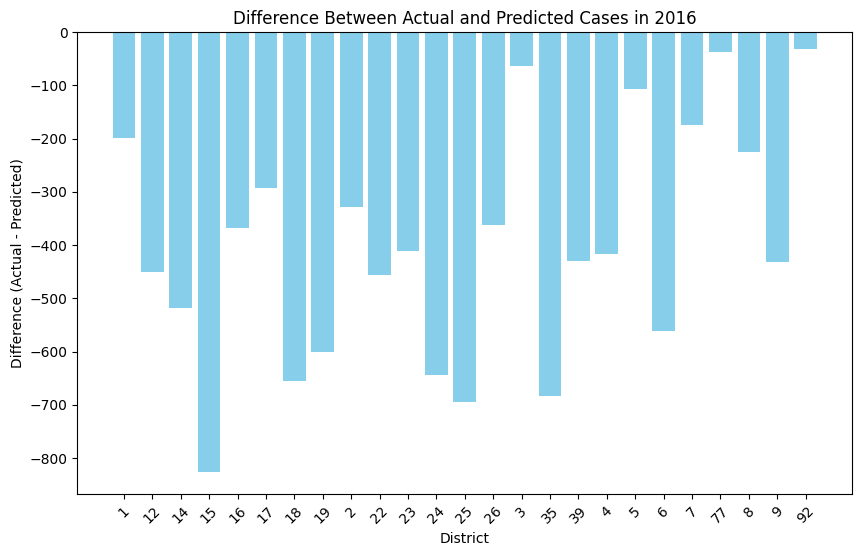

In [44]:
import matplotlib.pyplot as plt

# Convert the differences dictionary to a list for plotting
districts = list(differences.keys())
diff_values = list(differences.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(districts, diff_values, color='skyblue')
plt.xlabel('District')
plt.ylabel('Difference (Actual - Predicted)')
plt.title('Difference Between Actual and Predicted Cases in 2016')
plt.xticks(rotation=45)
plt.show()
